In [1]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import plotly.graph_objects as go
from plotly.offline import iplot

data_path = '/content/drive/My Drive/Analisis Netflix/netflix_titles.csv'
my_df = pd.read_csv(data_path)
my_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [2]:
my_df.shape

(8807, 12)

In [3]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [4]:
for i in range(len(my_df.isnull().sum())):
    if my_df.isnull().sum()[i] > 0:
        print('Total Number of missing values in ' + my_df.isnull().sum().index[i] + ' : ',my_df.isnull().sum()[i])

Total Number of missing values in director :  2634
Total Number of missing values in cast :  825
Total Number of missing values in country :  831
Total Number of missing values in date_added :  10
Total Number of missing values in rating :  4
Total Number of missing values in duration :  3


<ipython-input-4-be45c2e7187d>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-4-be45c2e7187d>:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Text(0.5, 1.0, 'Number of missing value\n')

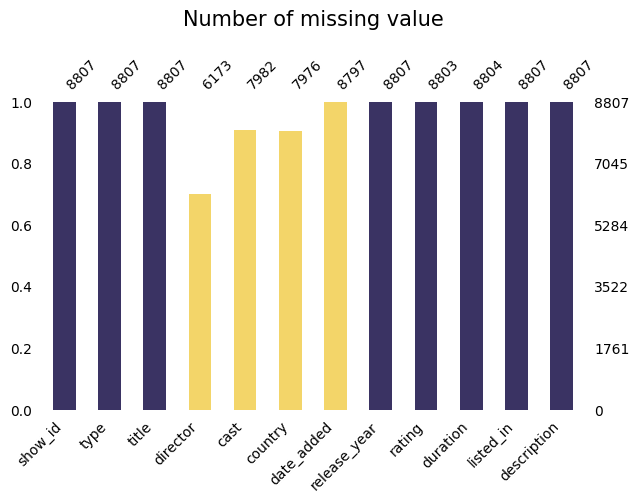

In [5]:
color= ['#3A3363','#3A3363','#3A3363','#F3D569','#F3D569','#F3D569','#F3D569','#3A3363','#3A3363','#3A3363','#3A3363','#3A3363']
missingno.bar(my_df,fontsize=10,color=color,figsize=(7,4))

plt.title('Number of missing value\n',fontsize=15)

In [6]:
my_df.drop(['duration','date_added'], axis=1 ,inplace=True)

In [7]:
my_df['director'] = my_df['director'].fillna('UnKnown')
my_df['country'] = my_df['country'].fillna('UnKnown')
my_df['cast'] = my_df['cast'].fillna('UnKnown')

In [8]:
rating_replacements = {5989: 'TV-PG', 6827: 'TV-14', 7312: 'PG', 7537: 'PG-13'}
for index, rating in rating_replacements.items():
    my_df.loc[index, 'rating'] = rating

my_df['rating'].isnull().any()

False

In [9]:
my_df['rating'] = my_df['rating'].replace({'74 min': 'TV-MA', '84 min': 'TV-MA', '66 min': 'TV-MA'})
my_df['rating'] = my_df['rating'].replace({'TV-Y7-FV': 'TV-Y7'})
my_df.isna().sum()

,0
show_id,0
type,0
title,0
director,0
cast,0
country,0
release_year,0
rating,0
listed_in,0
description,0


In [10]:
my_df.duplicated().sum()

0

In [11]:
my_df['rating'] = my_df['rating'].replace({
                                            'TV-MA': 'Adults',
                                            'R': 'Adults',
                                            'TV-Y': 'Kids',
                                            'TV-G': 'Kids',
                                            'G': 'Kids',
                                            'PG-13': 'Teens - Age above 12',
                                            'PG': 'Kids - with parental guidence',
                                            'TV-PG': 'Kids - with parental guidence',
                                            'TV-14': 'Teens - Age above 14',
                                            'TV-Y7': 'Kids - Age above 7',
                                            'NC-17': 'Adults',
                                            'UR' : 'UR',
                                            'NR': 'NR'
                                          })

my_df['rating'].unique()

array(['Teens - Age above 12', 'Adults', 'Kids - with parental guidence',
       'Teens - Age above 14', 'Kids', 'Kids - Age above 7', 'NR', 'UR'],
      dtype=object)

In [12]:
mydf_type = my_df.groupby('type')['show_id'].count().reset_index()
mydf_type = mydf_type.rename(columns = {"show_id":"count_showids"})
mydf_type

,type,count_showids
0,Movie,6131
1,TV Show,2676


In [13]:
my_df_new = my_df.copy()

bag_of_words_data = ['director', 'cast', 'listed_in','description']

for col in bag_of_words_data:
    my_df_new[col] = my_df_new[col].astype(str).map(lambda x : x.lower().replace(' ', '').split(',')[:3])

my_df_new['bag_of_words'] = ''

for i, row in my_df_new.iterrows():
    words = [' '.join(row[col]) for col in bag_of_words_data]
    my_df_new.loc[i, 'bag_of_words'] = ' '.join(words)

my_df_new.head()

,show_id,type,title,director,cast,country,release_year,rating,listed_in,description,bag_of_words
0,s1,Movie,Dick Johnson Is Dead,[kirstenjohnson],[unknown],United States,2020,Teens - Age above 12,[documentaries],"[asherfathernearstheendofhislife, filmmakerkir...",kirstenjohnson unknown documentaries asherfath...
1,s2,TV Show,Blood & Water,[unknown],"[amaqamata, khosingema, gailmabalane]",South Africa,2021,Adults,"[internationaltvshows, tvdramas, tvmysteries]","[aftercrossingpathsataparty, acapetownteensets...",unknown amaqamata khosingema gailmabalane inte...
2,s3,TV Show,Ganglands,[julienleclercq],"[samibouajila, tracygotoas, samueljouy]",UnKnown,2021,Adults,"[crimetvshows, internationaltvshows, tvaction&...","[toprotecthisfamilyfromapowerfuldruglord, skil...",julienleclercq samibouajila tracygotoas samuel...
3,s4,TV Show,Jailbirds New Orleans,[unknown],[unknown],UnKnown,2021,Adults,"[docuseries, realitytv]","[feuds, flirtationsandtoilettalkgodownamongthe...",unknown unknown docuseries realitytv feuds fli...
4,s5,TV Show,Kota Factory,[unknown],"[mayurmore, jitendrakumar, ranjanraj]",India,2021,Adults,"[internationaltvshows, romantictvshows, tvcome...",[inacityofcoachingcentersknowntotrainindia’sfi...,unknown mayurmore jitendrakumar ranjanraj inte...


In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = CountVectorizer(max_df=0.4,
                             min_df=1,
                             stop_words='english',
                             lowercase=True,
                             ngram_range=(1,3)
                            )

count_matrix = vectorizer.fit_transform(my_df_new['bag_of_words'])

In [15]:
mydf_TV = my_df[my_df['type'] == 'TV Show']

import plotly.express as px
fig = px.histogram(my_df, x='rating', color='type',
                   color_discrete_sequence=px.colors.qualitative.Pastel,
                   nbins=len(mydf_TV["rating"].unique()))

fig.update_layout(
    template='plotly_white',
    xaxis_title='Age Rating',
    yaxis_title='Count',
)

fig.show()

In [16]:
features_knn = ['type', 'country','release_year','rating','title']

my_df_knn = my_df[features_knn]

In [17]:
my_df_knn = pd.get_dummies(my_df_knn, columns=['type', 'rating', 'country'])

my_df_knn.reset_index(drop=True, inplace=True)

In [18]:
similarities = cosine_similarity(count_matrix, count_matrix)

dissimilarities = 1 - similarities

In [19]:
import math

def euclidean_distance(record1, record2, release_year_weighting=0.1):
    record1_features = np.array([record1[col] for col in my_df_knn.columns if col != 'title' and col != 'bag_of_words' and col != 'release_year'])
    record1_features = record1_features.astype(np.int16)
    record2_features = np.array([record2[col] for col in my_df_knn.columns if col != 'title' and col != 'bag_of_words' and col != 'release_year'])
    record2_features = record2_features.astype(np.int16)
    diffs = np.subtract(record1_features, record2_features)

    diff_release_year = release_year_weighting * (record1['release_year'] - record2['release_year'])
    diffs = np.append(diffs, [diff_release_year])

    return math.sqrt(np.sum([diff ** 2 for diff in diffs]))

In [20]:
def total_distance(record1_index, record2_index, bag_of_words_weighting=2):
    record1 = my_df_knn.iloc[record1_index]
    record2 = my_df_knn.iloc[record2_index]
    distance = euclidean_distance(record1, record2)
    distance += bag_of_words_weighting * dissimilarities[record1_index][record2_index]
    return distance

In [21]:
def get_recommendation_knn(title, top=5):
    all_titles = my_df_knn['title']
    title_instances = all_titles[all_titles == title]

    if title_instances.empty:
        print("Sorry! There isn't that movie in our database")
        return []

    curr_index = all_titles[all_titles == title].index[0]

    distances = list()

    for i, row in my_df_knn.iterrows():
        distances.append((row, total_distance(curr_index, i)))

    distances.sort(key=lambda tup: tup[1])
    results = list(map(lambda tup: tup[0]['title'], distances[1:top+1]))

    print(f"Recommendations for '{title}':")
    for res in results:
        print(res)

    return results

In [22]:
print("-"*40+"\n Recommendation for 'Ocean's Twelve'\n"+"-"*40)
result = get_recommendation_knn("Ocean's Twelve")
print(result)

----------------------------------------
 Recommendation for 'Ocean's Twelve'
----------------------------------------
Recommendations for 'Ocean's Twelve':
Ocean's Thirteen
Starsky & Hutch
Charlie's Angels: Full Throttle
The Dukes of Hazzard
Men in Black II
["Ocean's Thirteen", 'Starsky & Hutch', "Charlie's Angels: Full Throttle", 'The Dukes of Hazzard', 'Men in Black II']


In [23]:
print("-"*40+"\n Recommendation for 'PK'\n"+"-"*40)
result1 = get_recommendation_knn("PK")
print(result1)

----------------------------------------
 Recommendation for 'PK'
----------------------------------------
Recommendations for 'PK':
One by Two
Chal Bhaag
Jatt James Bond
Dedh Ishqiya
Ungli
['One by Two', 'Chal Bhaag', 'Jatt James Bond', 'Dedh Ishqiya', 'Ungli']


In [24]:
def find_movie(movie_name):
    test = []

    for i in range(len(my_df)):
        if my_df.iloc[i][2] == movie_name:
            test = my_df.iloc[i]
    return test

In [25]:
def Find_Difference(Original,recommended) :
    orgin_movie = find_movie(Original)
    first_pred = find_movie(recommended)
    print("=====================================================================================")
    listed_in_orgin_movie = orgin_movie[8]
    print("Genre for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[8]
    print("Genre for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

    listed_in_orgin_movie = orgin_movie[7]
    print("Rating for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[7]
    print("Rating for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

    listed_in_orgin_movie = orgin_movie[5]
    print("Genre for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[5]
    print("Genre for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

    listed_in_orgin_movie = orgin_movie[6]
    print("Genre for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[6]
    print("Genre for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

    listed_in_orgin_movie = orgin_movie[1]
    print("Genre for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[1]
    print("Genre for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

    listed_in_orgin_movie = orgin_movie[3]
    print("Genre for the original movie : ",listed_in_orgin_movie)

    listed_in_first_pred = first_pred[3]
    print("Genre for the recommended movie : ",listed_in_first_pred)
    print("=====================================================================================")

In [26]:
Find_Difference("Ocean's Twelve","Ocean's Thirteen")

<ipython-input-24-519f8a3c2905>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Genre for the original movie :  Action & Adventure, Comedies
Genre for the recommended movie :  Action & Adventure, Comedies
Rating for the original movie :  Teens - Age above 12
Rating for the recommended movie :  Teens - Age above 12
Genre for the original movie :  United States
Genre for the recommended movie :  United States
Genre for the original movie :  2004
Genre for the recommended movie :  2007
Genre for the original movie :  Movie
Genre for the recommended movie :  Movie
Genre for the original movie :  Steven Soderbergh
Genre for the recommended movie :  Steven Soderbergh


<ipython-input-25-3ece2d71fa94>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

In [27]:
Find_Difference("PK","One by Two")

<ipython-input-24-519f8a3c2905>:5: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



Genre for the original movie :  Comedies, Dramas, International Movies
Genre for the recommended movie :  Comedies, Dramas, International Movies
Rating for the original movie :  Teens - Age above 14
Rating for the recommended movie :  Teens - Age above 14
Genre for the original movie :  India
Genre for the recommended movie :  India
Genre for the original movie :  2014
Genre for the recommended movie :  2014
Genre for the original movie :  Movie
Genre for the recommended movie :  Movie
Genre for the original movie :  Rajkumar Hirani
Genre for the recommended movie :  Devika Bhagat


<ipython-input-25-3ece2d71fa94>:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:12: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:15: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-25-3ece2d71fa94>:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent